In [289]:
import pandas as pd
import json
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.integrate import trapezoid
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Load JSON
with open('combined_papers.json') as f:
    data = json.load(f)

print(f"✓ Data loaded successfully!")
print(f"Total curves: {len(data['curves'])}")
print(f"\nFirst curve structure:")
print(f"  - ID: {data['curves'][1]['curve_id']}")
print(f"  - Composition: {data['curves'][1]['alloy_composition']}")
print(f"  - Data points: {len(data['curves'][1]['curve_raw_data']['data'])}")

✓ Data loaded successfully!
Total curves: 392

First curve structure:
  - ID: fig14a-293K
  - Composition: {'Co': 20.0, 'Cr': 20.0, 'Fe': 20.0, 'Mn': 20.0, 'Ni': 20.0}
  - Data points: 35


In [290]:
def extract_features_from_curve(curve_data, debug=False):
    """
    Extract COMPREHENSIVE features from a stress-strain curve.
    This enhanced version includes ALL features including previously commented ones.
    """
    # === STEP 1: Check if data is valid ===
    if not curve_data or len(curve_data) < 6:
        if debug:
            print("⚠️ Skipping: Not enough data points")
        return None
    
    if debug:
        print(f"\n{'='*60}")
        print(f"Processing curve with {len(curve_data)} data points")
        print(f"{'='*60}")
    
    # === STEP 2: Convert to arrays ===
    strains_unsorted = np.array([p['x'] for p in curve_data])
    stresses_unsorted = np.array([p['y'] for p in curve_data])
    
    if debug:
        print(f"\n📊 Raw data ranges:")
        print(f"  Strain: {strains_unsorted.min():.4f} to {strains_unsorted.max():.4f}")
        print(f"  Stress: {stresses_unsorted.min():.2f} to {stresses_unsorted.max():.2f} MPa")
    
    # === STEP 3: Sort by strain ===
    sort_idx = np.argsort(strains_unsorted)
    strains = strains_unsorted[sort_idx]
    stresses = stresses_unsorted[sort_idx]
    
    if debug:
        print(f"\n✓ Data sorted by strain")
    
    # Initialize features dictionary
    features = {}
    
    # === STEP 4: Basic Mechanical Properties ===
    features['ultimate_tensile_strength'] = np.max(stresses)
    features['max_strain'] = np.max(strains)
    features['uts_strain'] = strains[np.argmax(stresses)]
    
    features['min_stress'] = np.min(stresses)
    features['min_strain'] = np.min(strains)
    
    if debug:
        print(f"\n🔧 Basic Properties:")
        print(f"  UTS: {features['ultimate_tensile_strength']:.2f} MPa")
        print(f"  Max Strain: {features['max_strain']:.4f}")
        print(f"  UTS occurs at strain: {features['uts_strain']:.4f}")
    
    # === STEP 5: Yield Strength (0.2% offset approximation) ===
    if strains[0] <= 0.002 <= strains[-1]:
        f_interp = interp1d(strains, stresses, kind='linear', fill_value='extrapolate', bounds_error=False)
        features['yield_strength_002'] = float(f_interp(0.002))
        if debug:
            print(f"  Yield Strength (0.2%): {features['yield_strength_002']:.2f} MPa")
    else:
        features['yield_strength_002'] = stresses[0]
        if debug:
            print(f"  Yield Strength (approx): {features['yield_strength_002']:.2f} MPa (using first point)")
    
    # Calculate YS/UTS ratio
    features['yield_to_uts_ratio'] = features['yield_strength_002'] / (features['ultimate_tensile_strength'] + 1e-10)
    
    # === STEP 6: Stress at specific strain points (ENABLED) ===
    strain_points = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]
    if debug:
        print(f"\n📍 Stress at specific strains:")
    
    for sp in strain_points:
        if strains[0] <= sp <= strains[-1]:
            f_interp = interp1d(strains, stresses, kind='linear', fill_value='extrapolate', bounds_error=False)
            features[f'stress_at_{sp}'] = float(f_interp(sp))
            if debug:
                print(f"  At ε={sp}: σ={features[f'stress_at_{sp}']:.2f} MPa")
        else:
            features[f'stress_at_{sp}'] = np.nan
    
    # === STEP 7: Elastic Modulus (Young's Modulus) ===
    # Estimate from initial linear portion (first 20% of data points)
    elastic_portion = int(len(strains) * 0.2)
    if elastic_portion > 2:
        elastic_strains = strains[:elastic_portion]
        elastic_stresses = stresses[:elastic_portion]
        # Linear fit: σ = E * ε + σ₀
        if len(elastic_strains) > 1 and (elastic_strains[-1] - elastic_strains[0]) > 1e-6:
            E_fit = np.polyfit(elastic_strains, elastic_stresses, 1)
            features['elastic_modulus'] = E_fit[0]  # Slope = Young's modulus
           
            features['elastic_intercept'] = E_fit[1]
        else:
            features['elastic_modulus'] = np.nan
            
            features['elastic_intercept'] = np.nan
    else:
        features['elastic_modulus'] = np.nan
        
        features['elastic_intercept'] = np.nan
    
    if debug:
        print(f"\n🔬 Elastic Properties:")
        print(f"  Elastic Modulus (E): {features.get('elastic_modulus', np.nan):.2f} MPa")
    
    # === STEP 8: Strain Hardening Exponent (n-value) ===
    # Fit power law: σ = K * εⁿ in the plastic region
    # Use data after yield point (strain > 0.002)
    plastic_mask = strains > 0.002
    if np.sum(plastic_mask) > 5:
        plastic_strains = strains[plastic_mask]
        plastic_stresses = stresses[plastic_mask]
        
        # Avoid log(0) or negative values
        valid_mask = (plastic_strains > 0) & (plastic_stresses > 0)
        if np.sum(valid_mask) > 3:
            try:
                # Log transform: log(σ) = log(K) + n * log(ε)
                log_strain = np.log(plastic_strains[valid_mask])
                log_stress = np.log(plastic_stresses[valid_mask])
                
                # Linear fit in log space
                n_fit = np.polyfit(log_strain, log_stress, 1)
                features['strain_hardening_exponent'] = n_fit[0]  # n-value
                features['strength_coefficient_K'] = np.exp(n_fit[1])  # K-value
            except:
                features['strain_hardening_exponent'] = np.nan
                features['strength_coefficient_K'] = np.nan
        else:
            features['strain_hardening_exponent'] = np.nan
            features['strength_coefficient_K'] = np.nan
    else:
        features['strain_hardening_exponent'] = np.nan
        features['strength_coefficient_K'] = np.nan
    
    if debug:
        print(f"  Strain hardening exponent (n): {features.get('strain_hardening_exponent', np.nan):.4f}")
        print(f"  Strength coefficient (K): {features.get('strength_coefficient_K', np.nan):.2f}")
    
    # === STEP 9: Work Hardening Analysis ===
    if len(strains) > 5:
        # Smooth the curve
        window = min(5, len(stresses) if len(stresses) % 2 == 1 else len(stresses) - 1)
        if window >= 3:
            stresses_smooth = savgol_filter(stresses, window, 2)
        else:
            stresses_smooth = stresses
        
        # Calculate hardening rate (dσ/dε)
        d_stress = np.diff(stresses_smooth)
        d_strain = np.diff(strains)
        hardening_rate = d_stress / (d_strain + 1e-10)
        
        features['avg_hardening_rate'] = np.mean(hardening_rate)
       
        features['max_hardening_rate'] = np.max(hardening_rate)
        features['min_hardening_rate'] = np.min(hardening_rate)
        features['std_hardening_rate'] = np.std(hardening_rate)
        
        # Hardening at different stages
        n_points = len(hardening_rate)
        if n_points >= 3:
            features['hardening_rate_early'] = np.mean(hardening_rate[:n_points//3])
            features['hardening_rate_mid'] = np.mean(hardening_rate[n_points//3:2*n_points//3])
            features['hardening_rate_late'] = np.mean(hardening_rate[2*n_points//3:])
        else:
            features['hardening_rate_early'] = np.mean(hardening_rate)
            features['hardening_rate_mid'] = np.mean(hardening_rate)
            features['hardening_rate_late'] = np.mean(hardening_rate)
        
        # Hardening rate ratios
        features['hardening_rate_ratio_early_mid'] = features['hardening_rate_early'] / (features['hardening_rate_mid'] + 1e-10)
        
        features['hardening_rate_ratio_mid_late'] = features['hardening_rate_mid'] / (features['hardening_rate_late'] + 1e-10)
        
        if debug:
            print(f"\n⚙️ Work Hardening (dσ/dε):")
            print(f"  Average: {features['avg_hardening_rate']:.2f}")
            
            print(f"  Max: {features['max_hardening_rate']:.2f}")
            print(f"  Min: {features['min_hardening_rate']:.2f}")
    
    # === STEP 10: Energy Metrics ===
    features['toughness'] = trapezoid(stresses, strains)
    elastic_idx = int(len(strains) * 0.2)
    if elastic_idx > 1:
        features['resilience'] = trapezoid(stresses[:elastic_idx], strains[:elastic_idx])
    else:
        features['resilience'] = 0
    
    # Energy at different strain ranges
    mid_idx = len(strains) // 2
    features['energy_elastic_region'] = trapezoid(stresses[:elastic_idx], strains[:elastic_idx]) if elastic_idx > 1 else 0
    features['energy_plastic_region'] = trapezoid(stresses[elastic_idx:], strains[elastic_idx:]) if len(strains) > elastic_idx else 0
    
    # Energy ratio
    features['plastic_to_elastic_energy'] = features['energy_plastic_region'] / (features['energy_elastic_region'] + 1e-10)
    
    if debug:
        print(f"\n⚡ Energy:")
        print(f"  Toughness (total): {features['toughness']:.2f}")
        print(f"  Resilience (elastic): {features['resilience']:.2f}")
    
    # === STEP 11: Statistical Features (ENABLED) ===
    features['stress_mean'] = np.mean(stresses)
    features['stress_std'] = np.std(stresses)
    
    features['stress_median'] = np.median(stresses)
    features['stress_25_percentile'] = np.percentile(stresses, 25)
    features['stress_75_percentile'] = np.percentile(stresses, 75)
    features['stress_range'] = np.max(stresses) - np.min(stresses)
    features['stress_cv'] = features['stress_std'] / (features['stress_mean'] + 1e-10)  # Coefficient of variation
    
    # Strain statistics
    features['strain_mean'] = np.mean(strains)
    
    features['strain_std'] = np.std(strains)
    # Note: strain_range is kept in STEP 12
    
    if debug:
        print(f"\n📊 Statistics:")
        print(f"  Stress Mean: {features['stress_mean']:.2f} MPa")
        print(f"  Stress Std: {features['stress_std']:.2f} MPa")
    
    # === STEP 12: Curve Shape Features (ENABLED) ===
   
    features['num_data_points'] = len(strains)
    features['strain_range'] = np.max(strains) - np.min(strains)
    
    n = len(strains)
   
    if n >= 4:
        # Early slope (0-25%)
        early_idx = max(1, n // 4)
        early_slope = (stresses[early_idx] - stresses[0]) / (strains[early_idx] - strains[0] + 1e-10)
        features['early_slope'] = early_slope
        
        # Mid slope (25-50%)
        mid_idx = n // 2
        mid_slope = (stresses[mid_idx] - stresses[early_idx]) / (strains[mid_idx] - strains[early_idx] + 1e-10)
        features['mid_slope'] = mid_slope
        
        # Late slope (50-100%)
        late_slope = (stresses[-1] - stresses[mid_idx]) / (strains[-1] - strains[mid_idx] + 1e-10)
        features['late_slope'] = late_slope
        
        # Slope ratios
        features['slope_ratio_early_mid'] = early_slope / (mid_slope + 1e-10)
        features['slope_ratio_mid_late'] = mid_slope / (late_slope + 1e-10)
    else:
        features['early_slope'] = np.nan
        features['mid_slope'] = np.nan
        features['late_slope'] = np.nan
        features['slope_ratio_early_mid'] = np.nan
        features['slope_ratio_mid_late'] = np.nan
    
    # Curve curvature (second derivative approximation)
   
    if n > 2:
        # Approximate second derivative
        second_deriv = np.diff(np.diff(stresses)) / (np.diff(strains[:-1]) + 1e-10) ** 2
        features['avg_curvature'] = np.mean(second_deriv)
        features['max_curvature'] = np.max(np.abs(second_deriv))
    else:
        features['avg_curvature'] = np.nan
        features['max_curvature'] = np.nan
    
    # === STEP 13: Stress Ratios ===
    # Ratios between stress at different strain points
  
    if 'stress_at_0.1' in features and 'stress_at_0.01' in features and not np.isnan(features['stress_at_0.1']) and not np.isnan(features['stress_at_0.01']):
        features['stress_ratio_0.1_to_0.01'] = features['stress_at_0.1'] / (features['stress_at_0.01'] + 1e-10)
    else:
        features['stress_ratio_0.1_to_0.01'] = np.nan
    
    # Keep this one (stress_ratio_0.2_to_0.1 is in top 30):
    if 'stress_at_0.2' in features and 'stress_at_0.1' in features and not np.isnan(features['stress_at_0.2']) and not np.isnan(features['stress_at_0.1']):
        features['stress_ratio_0.2_to_0.1'] = features['stress_at_0.2'] / (features['stress_at_0.1'] + 1e-10)
    else:
        features['stress_ratio_0.2_to_0.1'] = np.nan
    
    # === STEP 14: Detect True vs Engineering Stress-Strain ===
   
    # Engineering: stress can decrease after necking
    # True: stress should generally increase (with exception at very end)
    # Check if stress decreases significantly in last 20% of curve
    last_portion = int(len(stresses) * 0.8)
    if last_portion < len(stresses):
        last_stress_avg = np.mean(stresses[last_portion:])
        peak_stress = np.max(stresses[:last_portion])
        stress_drop_ratio = (peak_stress - last_stress_avg) / (peak_stress + 1e-10)
        features['is_likely_engineering'] = 1.0 if stress_drop_ratio > 0.05 else 0.0
        features['stress_drop_ratio'] = stress_drop_ratio
    else:
        features['is_likely_engineering'] = 0.0
        features['stress_drop_ratio'] = 0.0
    
    if debug:
        print(f"\n✅ Feature extraction complete! Total features: {len(features)}")
    
    return features

print("✓ Enhanced feature extraction function defined!")


✓ Enhanced feature extraction function defined!


In [267]:
# def extract_features_from_curve(curve_data, debug=False):
#     """
#     Extract comprehensive features from a stress-strain curve.
#     Set debug=True to see intermediate calculations.
#     """
#     # === STEP 1: Check if data is valid ===
#     if not curve_data or len(curve_data) < 6:
#         if debug:
#             print(" Skipping: Not enough data points")
#         return None
    
#     if debug:
#         print(f"\n{'='*60}")
#         print(f"Processing curve with {len(curve_data)} data points")
#         print(f"{'='*60}")
    
#     # === STEP 2: Convert to arrays ===
#     strains_unsorted = np.array([p['x'] for p in curve_data])
#     stresses_unsorted = np.array([p['y'] for p in curve_data])
    
#     if debug:
#         print(f"\n Raw data ranges:")
#         print(f"  Strain: {strains_unsorted.min():.4f} to {strains_unsorted.max():.4f}")
#         print(f"  Stress: {stresses_unsorted.min():.2f} to {stresses_unsorted.max():.2f} MPa")
    
#     # === STEP 3: Sort by strain ===
#     sort_idx = np.argsort(strains_unsorted)
#     strains = strains_unsorted[sort_idx]
#     stresses = stresses_unsorted[sort_idx]
    
#     if debug:
#         print(f"\n✓ Data sorted by strain")
    
#     # Initialize features dictionary
#     features = {}
    
#     # === STEP 4: Basic Mechanical Properties ===
#     features['ultimate_tensile_strength'] = np.max(stresses)
#     features['max_strain'] = np.max(strains)
#     features['uts_strain'] = strains[np.argmax(stresses)]
    
#     if debug:
#         print(f"\n🔧 Basic Properties:")
#         print(f"  UTS: {features['ultimate_tensile_strength']:.2f} MPa")
#         print(f"  Max Strain: {features['max_strain']:.4f}")
#         print(f"  UTS occurs at strain: {features['uts_strain']:.4f}")
    
#     # === STEP 5: Yield Strength (0.2% offset approximation) ===
#     if strains[0] <= 0.002 <= strains[-1]:
#         f_interp = interp1d(strains, stresses, kind='linear', fill_value='extrapolate')
#         features['yield_strength_002'] = float(f_interp(0.002))
#         if debug:
#             print(f"  Yield Strength (0.2%): {features['yield_strength_002']:.2f} MPa")
#     else:
#         features['yield_strength_002'] = stresses[0]
#         if debug:
#             print(f"  Yield Strength (approx): {features['yield_strength_002']:.2f} MPa (using first point)")
    
#     # === STEP 6: Stress at specific strain points ===
#     # strain_points = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]
#     # if debug:
#     #     print(f"\n📍 Stress at specific strains:")
    
#     # for sp in strain_points:
#     #     if strains[0] <= sp <= strains[-1]:
#     #         f_interp = interp1d(strains, stresses, kind='linear', fill_value='extrapolate')
#     #         features[f'stress_at_{sp}'] = float(f_interp(sp))
#     #         if debug:
#     #             print(f"  At ε={sp}: σ={features[f'stress_at_{sp}']:.2f} MPa")
#     #     else:
#     #         features[f'stress_at_{sp}'] = np.nan
#     #         if debug:
#     #             print(f"  At ε={sp}: N/A (outside range)")
    
#     # # === STEP 7: Work Hardening Analysis ===
#     if len(strains) > 5:
#         # Smooth the curve
#         window = min(5, len(stresses) if len(stresses) % 2 == 1 else len(stresses) - 1)
#         if window >= 3:
#             stresses_smooth = savgol_filter(stresses, window, 2)
#         else:
#             stresses_smooth = stresses
        
#         # Calculate hardening rate (dσ/dε)
#         d_stress = np.diff(stresses_smooth)
#         d_strain = np.diff(strains)
#         hardening_rate = d_stress / (d_strain + 1e-10)
        
#         features['avg_hardening_rate'] = np.mean(hardening_rate)
#         features['max_hardening_rate'] = np.max(hardening_rate)
#         features['min_hardening_rate'] = np.min(hardening_rate)
#         features['std_hardening_rate'] = np.std(hardening_rate)
        
#         # Hardening at different stages
#         n_points = len(hardening_rate)
#         features['hardening_rate_early'] = np.mean(hardening_rate[:n_points//3])
#         features['hardening_rate_mid'] = np.mean(hardening_rate[n_points//3:2*n_points//3])
#         features['hardening_rate_late'] = np.mean(hardening_rate[2*n_points//3:])
        
#         if debug:
#             print(f"\n⚙️ Work Hardening (dσ/dε):")
#             print(f"  Average: {features['avg_hardening_rate']:.2f}")
#             print(f"  Max: {features['max_hardening_rate']:.2f}")
#             print(f"  Min: {features['min_hardening_rate']:.2f}")
#             print(f"  Early stage: {features['hardening_rate_early']:.2f}")
#             print(f"  Mid stage: {features['hardening_rate_mid']:.2f}")
#             print(f"  Late stage: {features['hardening_rate_late']:.2f}")
    
#     # === STEP 8: Energy Metrics ===
#     features['toughness'] = np.trapz(stresses, strains)
#     elastic_idx = int(len(strains) * 0.2)
#     features['resilience'] = np.trapz(stresses[:elastic_idx], strains[:elastic_idx])
    
#     if debug:
#         print(f"\n⚡ Energy:")
#         print(f"  Toughness (total): {features['toughness']:.2f}")
#         print(f"  Resilience (elastic): {features['resilience']:.2f}")
    
#     # === STEP 9: Statistical Features ===
#     # features['stress_mean'] = np.mean(stresses)
#     # features['stress_std'] = np.std(stresses)
#     # features['stress_median'] = np.median(stresses)
#     # features['stress_25_percentile'] = np.percentile(stresses, 25)
#     # features['stress_75_percentile'] = np.percentile(stresses, 75)
#     # features['stress_range'] = np.max(stresses) - np.min(stresses)
    
#     # if debug:
#     #     print(f"\n📊 Statistics:")
#     #     print(f"  Mean: {features['stress_mean']:.2f} MPa")
#     #     print(f"  Std: {features['stress_std']:.2f} MPa")
#     #     print(f"  Median: {features['stress_median']:.2f} MPa")
    
#     # # === STEP 10: Curve Shape Features ===
#     # features['num_data_points'] = len(strains)
#     # features['strain_range'] = np.max(strains) - np.min(strains)
    
#     # n = len(strains)
#     # early_slope = (stresses[n//4] - stresses[0]) / (strains[n//4] - strains[0] + 1e-10)
#     # mid_slope = (stresses[n//2] - stresses[n//4]) / (strains[n//2] - strains[n//4] + 1e-10)
#     # late_slope = (stresses[-1] - stresses[n//2]) / (strains[-1] - strains[n//2] + 1e-10)
    
#     # features['early_slope'] = early_slope
#     # features['mid_slope'] = mid_slope
#     # features['late_slope'] = late_slope
    
#     # if debug:
#     #     print(f"\n📈 Slopes:")
#     #     print(f"  Early (0-25%): {features['early_slope']:.2f}")
#     #     print(f"  Mid (25-50%): {features['mid_slope']:.2f}")
#     #     print(f"  Late (50-100%): {features['late_slope']:.2f}")
#         print(f"\n✅ Feature extraction complete! Total features: {len(features)}")
    
#     return features

# print("✓ Function defined successfully!")

In [291]:
# Test on the first curve with debug mode ON
# print("🔍 Testing feature extraction on FIRST curve:\n")
# test_features = extract_features_from_curve(
#     data['curves'][0]['curve_raw_data']['data'], 
#     debug=True
# )
# Test enhanced feature extraction
print("🔍 Testing ENHANCED feature extraction on FIRST curve:\n")
test_features = extract_features_from_curve(
    data['curves'][0]['curve_raw_data']['data'], 
    debug=True
)

print(f"\n\n📋 Total features extracted: {len(test_features)}")
print(f"\nFeature list:")
for i, (key, value) in enumerate(test_features.items(), 1):
    if not np.isnan(value):
        print(f"  {i:2d}. {key:35s} = {value:.4f}")
    else:
        print(f"  {i:2d}. {key:35s} = NaN")


# print(f"\n\n📋 Extracted features:")
# for key, value in test_features.items():
#     print(f"  {key}: {value}")

🔍 Testing ENHANCED feature extraction on FIRST curve:


Processing curve with 50 data points

📊 Raw data ranges:
  Strain: 0.0110 to 0.8900
  Stress: 592.33 to 1115.82 MPa

✓ Data sorted by strain

🔧 Basic Properties:
  UTS: 1115.82 MPa
  Max Strain: 0.8900
  UTS occurs at strain: 0.8280
  Yield Strength (approx): 592.33 MPa (using first point)

📍 Stress at specific strains:
  At ε=0.02: σ=615.89 MPa
  At ε=0.05: σ=676.93 MPa
  At ε=0.1: σ=747.66 MPa
  At ε=0.2: σ=857.54 MPa
  At ε=0.3: σ=945.82 MPa
  At ε=0.5: σ=1056.02 MPa

🔬 Elastic Properties:
  Elastic Modulus (E): 1636.97 MPa
  Strain hardening exponent (n): 0.1730
  Strength coefficient (K): 1159.51

⚙️ Work Hardening (dσ/dε):
  Average: 657.86
  Max: 2764.29
  Min: -866.08

⚡ Energy:
  Toughness (total): 860.18
  Resilience (elastic): 74.91

📊 Statistics:
  Stress Mean: 950.20 MPa
  Stress Std: 161.91 MPa

✅ Feature extraction complete! Total features: 54


📋 Total features extracted: 54

Feature list:
   1. ultimate_tensile_st

In [292]:
def normalize_composition(composition_dict):
    """
    Normalize composition dictionary keys to standard element symbols,
    convert wt.% to at.% if needed, and SKIP non-element keys.
    """
    import re
    
    # Valid chemical elements
    VALID_ELEMENTS = {
        'Al', 'Co', 'Cr', 'Cu', 'Fe', 'Mg', 'Mn', 'Mo', 'Nb', 'Nd', 
        'Ni', 'Si', 'Ti', 'V', 'W', 'Y', 'Zn', 'Zr', 'C', 'N', 'O', 
        'S', 'P', 'B', 'H', 'Li', 'Be', 'Ca', 'Sc', 'Ga', 'Ge', 'As',
        'Se', 'Ag', 'Sn', 'Sb', 'Ta', 'Hf', 'Re', 'Pd', 'Pt', 'Au'
    }
    
    # Atomic weights (g/mol)
    ATOMIC_WEIGHTS = {
        'Al': 26.982, 'Co': 58.933, 'Cr': 51.996, 'Cu': 63.546,
        'Fe': 55.845, 'Mg': 24.305, 'Mn': 54.938, 'Mo': 95.95,
        'Nb': 92.906, 'Nd': 144.242, 'Ni': 58.693, 'Si': 28.085,
        'Ti': 47.867, 'V': 50.942, 'W': 183.84, 'Y': 88.906,
        'Zn': 65.38, 'Zr': 91.224, 'C': 12.011, 'N': 14.007,
        'O': 15.999, 'S': 32.06, 'P': 30.974, 'B': 10.81,
        'Ta': 180.948, 'Hf': 178.49
    }
    
    # Check if conversion is needed
    needs_conversion = any('wt' in str(key).lower() for key in composition_dict.keys())
    
    # Step 1: Clean keys and filter out non-elements
    cleaned = {}
    skipped_keys = []
    
    for key, value in composition_dict.items():
        # Skip if value is not a number
        try:
            float(value)
        except (ValueError, TypeError):
            skipped_keys.append(key)
            continue
        
        # Clean the key
        clean_key = re.sub(r'\s*\(wt\.?%?\)|\s*\(at\.?%?\)|\s*_wt%?|\s*_at%?|\s*wt%?|\s*at%?', 
                          '', key, flags=re.IGNORECASE)
        clean_key = clean_key.strip()
        
        # Standardize capitalization
        if len(clean_key) == 1:
            clean_key = clean_key.upper()
        elif len(clean_key) >= 2:
            clean_key = clean_key[0].upper() + clean_key[1:].lower()
        
        # ✅ ONLY ADD IF IT'S A VALID ELEMENT
        if clean_key in VALID_ELEMENTS:
            cleaned[clean_key] = float(value)
        else:
            skipped_keys.append(key)
    
    if skipped_keys:
        pass  # Silently skip non-element keys
        # Uncomment below to see what was skipped
        # print(f"    ⏩ Skipped non-element keys: {skipped_keys}")
    
    # Step 2: Convert wt.% to at.% if needed
    if needs_conversion and cleaned:
        mole_fractions = {}
        for element, wt_percent in cleaned.items():
            if element in ATOMIC_WEIGHTS:
                mole_fractions[element] = wt_percent / ATOMIC_WEIGHTS[element]
            else:
                mole_fractions[element] = wt_percent
        
        total_moles = sum(mole_fractions.values())
        
        if total_moles > 0:
            at_percent = {elem: (moles / total_moles) * 100 
                         for elem, moles in mole_fractions.items()}
            return at_percent
    
    return cleaned

In [293]:
# Extract for ALL curves with normalization, conversion, AND filtering
feature_list = []
composition_list = []
skipped = 0
converted_count = 0

print("Processing all curves (filtering non-element columns)...")
for i, curve in enumerate(data['curves']):
    features = extract_features_from_curve(curve['curve_raw_data']['data'], debug=False)
    
    if features is not None:
        # Check if this needs conversion
        original_comp = curve['alloy_composition']
        needs_conversion = any('wt' in str(key).lower() for key in original_comp.keys())
        
        if needs_conversion:
            converted_count += 1
        
        # Normalize, convert, AND filter non-elements
        normalized_comp = normalize_composition(original_comp)
        
        # Only add if we have valid composition data
        if normalized_comp:
            feature_list.append(features)
            composition_list.append(normalized_comp)
        else:
            skipped += 1
    else:
        skipped += 1
    
    # Progress indicator
    if (i + 1) % 50 == 0:
        print(f"  Processed {i+1}/{len(data['curves'])} curves...")

print(f"\n✓ Feature extraction complete!")
print(f"  Successfully processed: {len(feature_list)} curves")
print(f"  Converted wt%→at%: {converted_count} curves")
print(f"  Skipped (insufficient data): {skipped} curves")


   

Processing all curves (filtering non-element columns)...
  Processed 50/392 curves...
  Processed 100/392 curves...
  Processed 150/392 curves...
  Processed 200/392 curves...
  Processed 250/392 curves...
  Processed 300/392 curves...
  Processed 350/392 curves...

✓ Feature extraction complete!
  Successfully processed: 382 curves
  Converted wt%→at%: 16 curves
  Skipped (insufficient data): 10 curves


In [294]:
# Create DataFrames
X = pd.DataFrame(feature_list)
y = pd.DataFrame(composition_list)

# Fill any missing element values with 0
y = y.fillna(0)

print(f"\n{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")
print(f"\nFeature matrix (X) shape: {X.shape}")
print(f"Target matrix (y) shape: {y.shape}")

# print(f"\n Feature names ({len(X.columns)} total):")
# for i, col in enumerate(X.columns, 1):
#     print(f"  {i}. {col}")

print(f"\nTarget (composition) names ({len(y.columns)} total):")
for i, col in enumerate(y.columns, 1):
    print(f"  {i}. {col}")

# print(f"\n🧪 First 5 rows of features:")
# print(X.head())

# print(f"\n🎯 First 5 rows of compositions:")
# print(y.head())




FINAL RESULTS

Feature matrix (X) shape: (382, 54)
Target matrix (y) shape: (382, 22)

Target (composition) names (22 total):
  1. Co
  2. Cr
  3. Fe
  4. Mn
  5. Ni
  6. Al
  7. Cu
  8. V
  9. Si
  10. Mg
  11. Y
  12. Nd
  13. Zr
  14. Ti
  15. C
  16. Mo
  17. Ta
  18. Hf
  19. B
  20. Nb
  21. W
  22. N


In [295]:
# Check for NaN values
missing = X.isnull().sum()
if missing.sum() > 0:
    print("\n⚠️ Missing values found:")
    print(missing[missing > 0])
    
    # Fill with median
    X_filled = X.fillna(X.median())
    print(f"\n✓ Missing values filled with median")
    print(f"  Before: {X.isnull().sum().sum()} NaN values")
    print(f"  After: {X_filled.isnull().sum().sum()} NaN values")
    X = X_filled
else:
    print("\n✅ No missing values!")


⚠️ Missing values found:
yield_strength_002            8
yield_to_uts_ratio            8
stress_at_0.01              135
stress_at_0.02               73
stress_at_0.05               40
stress_at_0.1                57
stress_at_0.2               132
stress_at_0.3               209
stress_at_0.5               305
elastic_modulus              12
elastic_intercept            12
stress_ratio_0.1_to_0.01    176
stress_ratio_0.2_to_0.1     137
dtype: int64

✓ Missing values filled with median
  Before: 1304 NaN values
  After: 0 NaN values


In [296]:
from sklearn.feature_selection import VarianceThreshold

print("\n🔍 Checking for low-variance features:")
print(f"Features before: {X.shape[1]}")

# Remove features with variance < 0.01
selector = VarianceThreshold(threshold=0.01)
X_high_var = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]

X = pd.DataFrame(X_high_var, columns=selected_features, index=X.index)
print(f"Features after: {X.shape[1]}")
print(f"✓ Removed {len(X.columns) - X.shape[1]} low-variance features")


🔍 Checking for low-variance features:
Features before: 54
Features after: 54
✓ Removed 0 low-variance features



📊 Checking feature distributions:


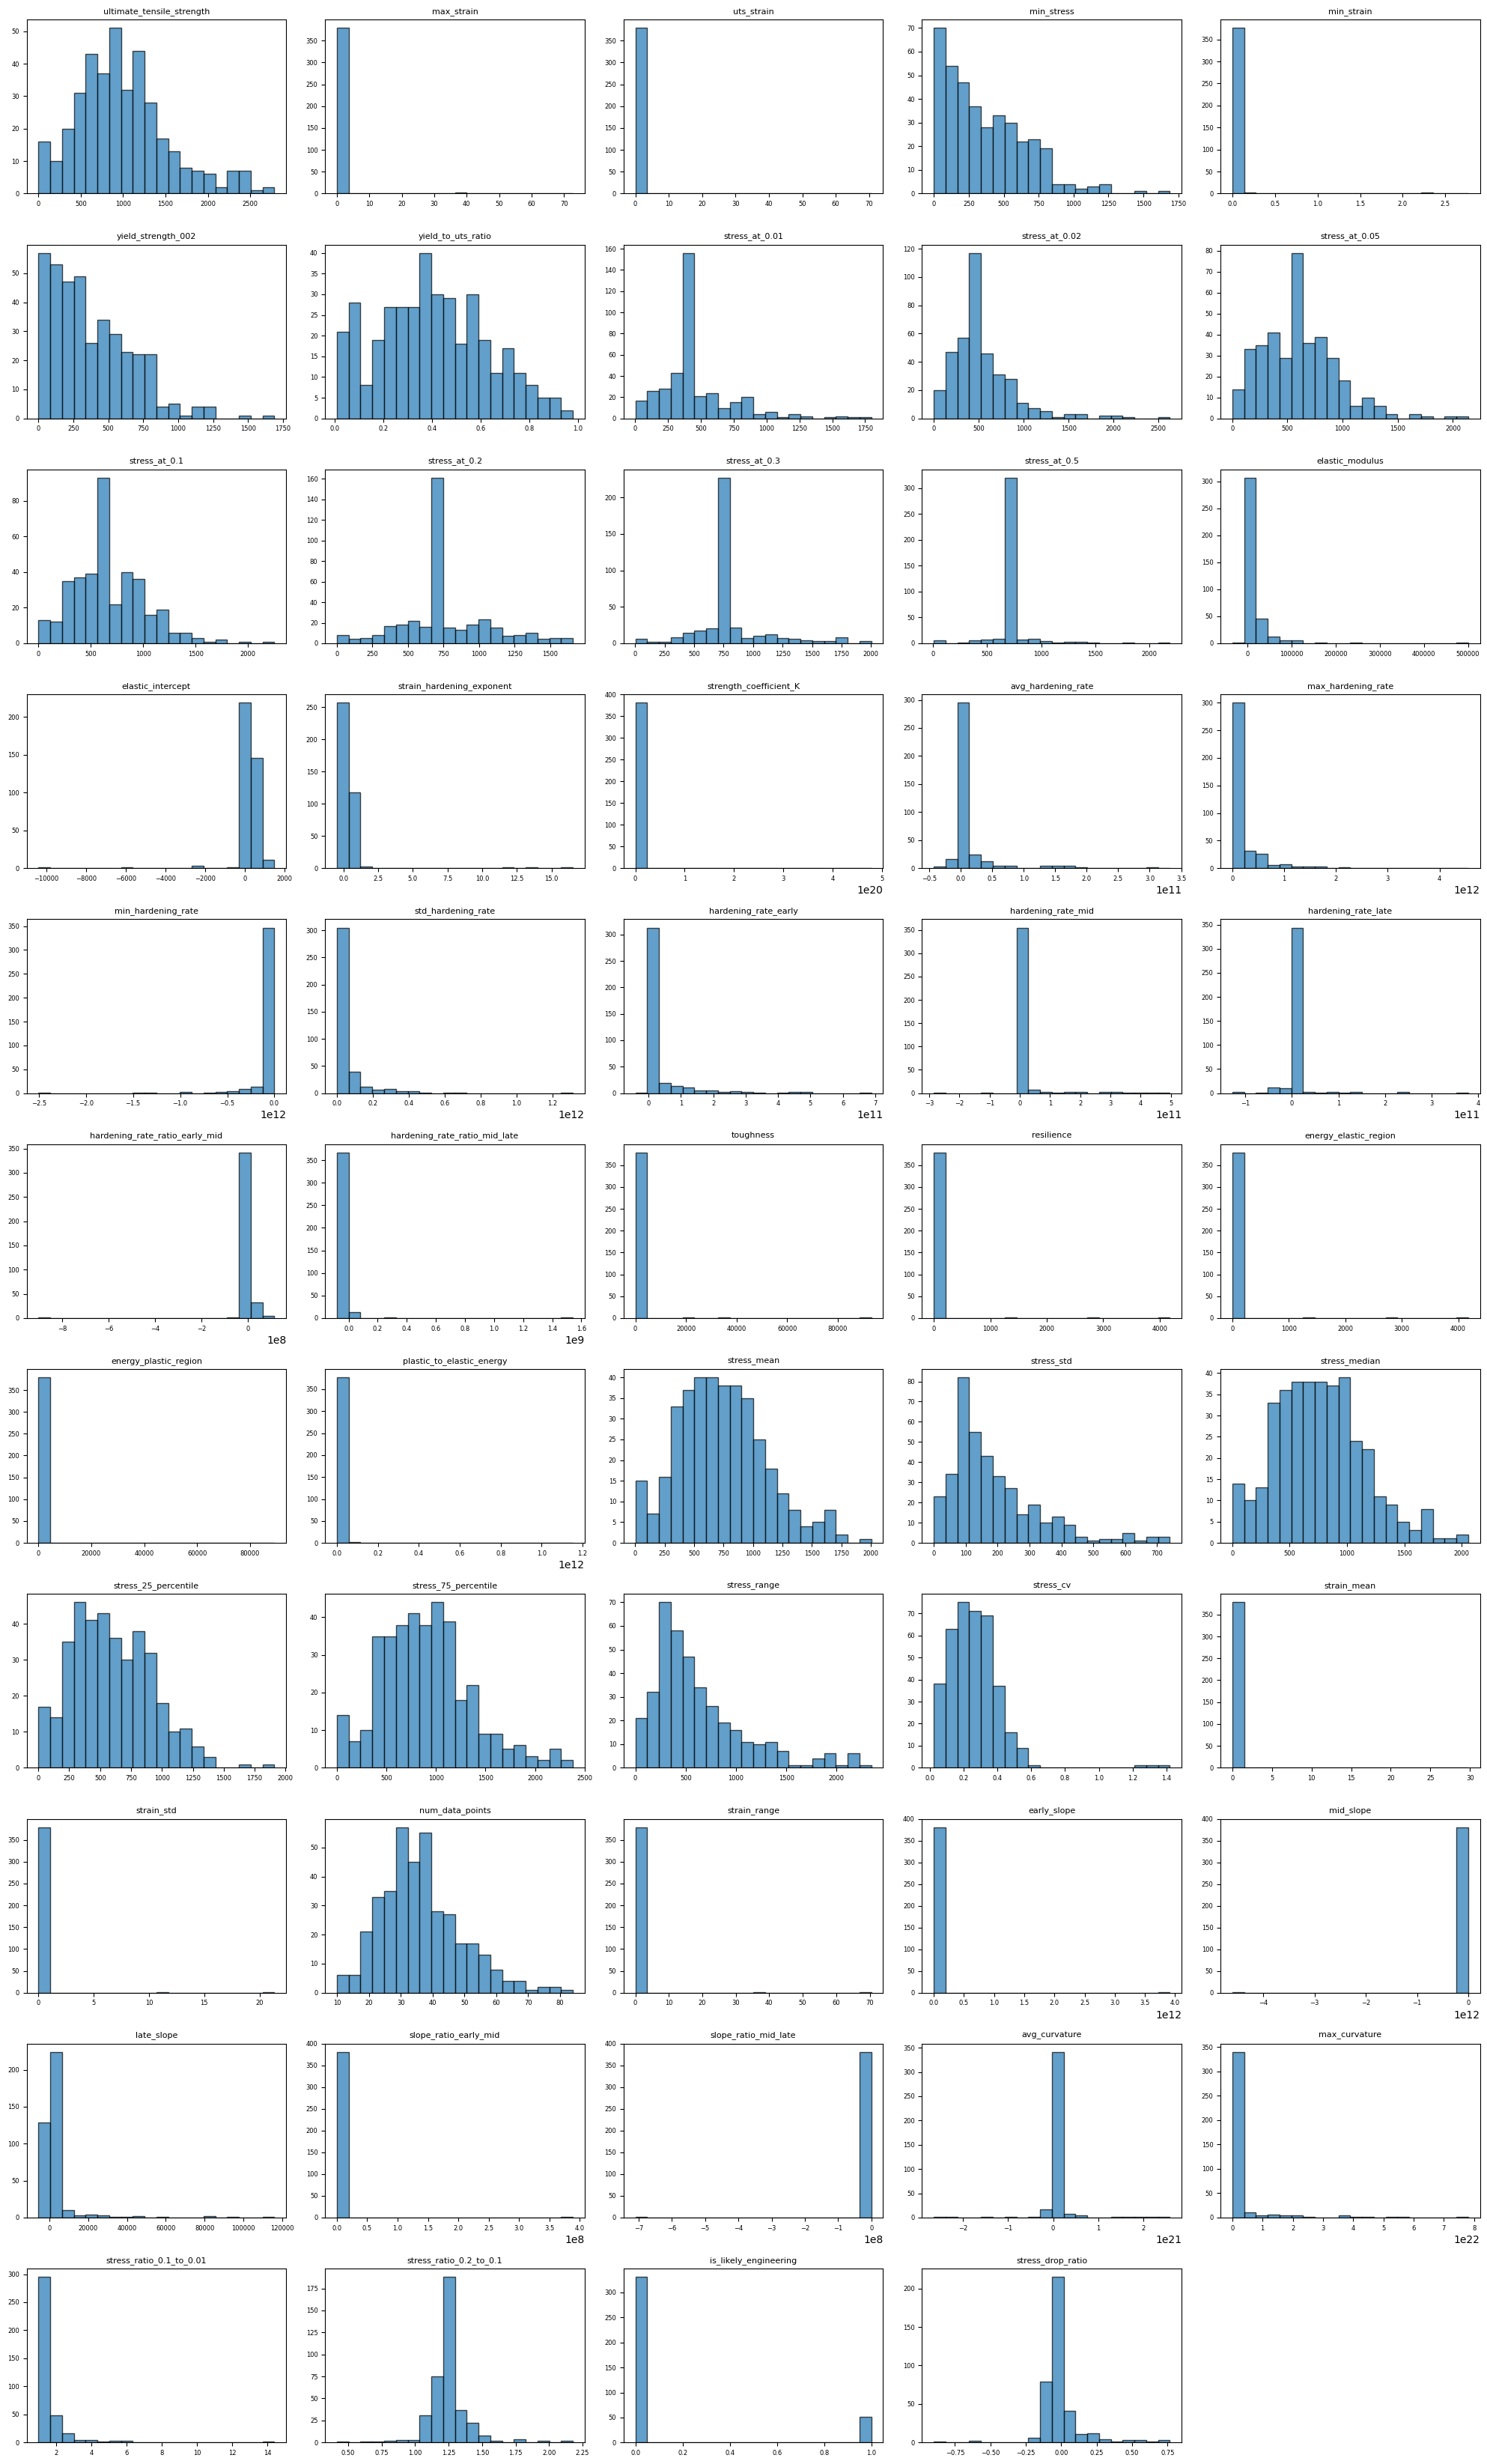

✓ Check the plots for any extreme outliers or skewed distributions


In [297]:
import matplotlib.pyplot as plt
import numpy as np

print("\n📊 Checking feature distributions:")

num_features = len(X.columns)
cols = 5  # 5 plots per row
rows = int(np.ceil(num_features / cols))  # enough rows to fit all

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    axes[i].hist(X[col].dropna(), bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_title(col, fontsize=8)
    axes[i].tick_params(labelsize=6)

# Turn off unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

print("✓ Check the plots for any extreme outliers or skewed distributions")



📊 Target (composition) distribution:
               Co          Cr          Fe          Mn          Ni          Al  \
count  382.000000  382.000000  382.000000  382.000000  382.000000  382.000000   
mean    16.526356   15.991147   24.738267    9.453770   16.365762    4.496736   
std      8.556405    8.274362   15.833242   12.076733   14.532017    6.673541   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     10.000000   14.800000   16.390000    0.000000    0.000000    0.000000   
50%     18.200000   16.390000   22.455000    0.000000   20.000000    0.000000   
75%     20.800000   20.000000   38.500000   20.000000   25.000000    9.000000   
max     34.000000   39.390000   72.670000   45.000000   73.125000   25.000000   

               Cu           V          Si          Mg  ...          Zr  \
count  382.000000  382.000000  382.000000  382.000000  ...  382.000000   
mean     1.807853    0.627749    1.058901    4.109029  ...    0.402691   
std      5

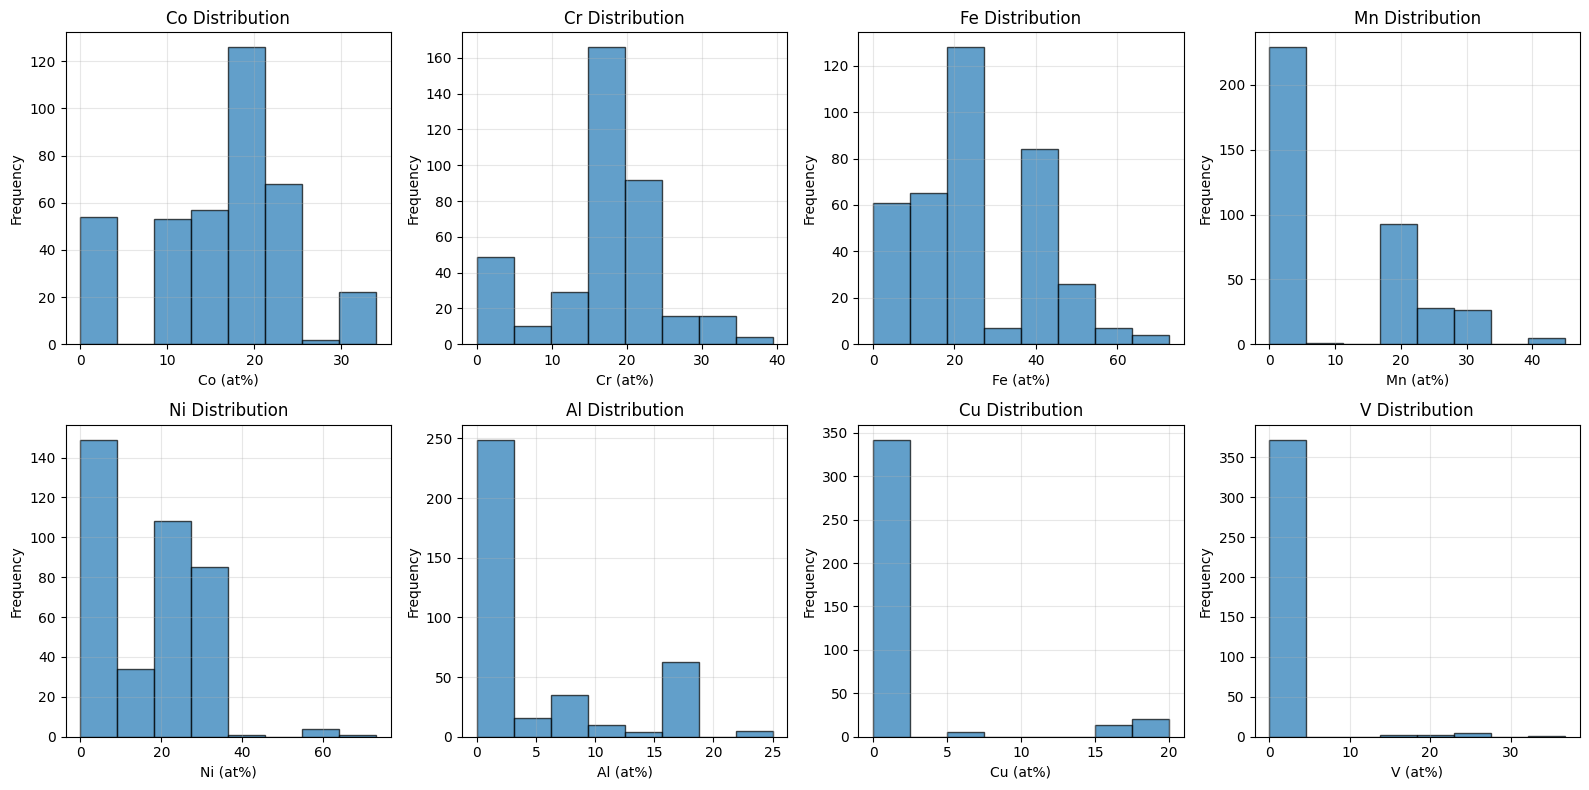


✓ Check if any elements are rarely present (may cause issues)


In [275]:
# Check if compositions are balanced
print("\n📊 Target (composition) distribution:")
print(y.describe())

# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(y.columns[:8]):  # First 8 elements
    axes[i].hist(y[col], bins=8, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(f'{col} (at%)')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{col} Distribution')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Check if any elements are rarely present (may cause issues)")

In [298]:
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)  # y should have all 22 columns


In [299]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nData Split Summary:")
print(f"  Training samples (X): {X_train.shape[0]}")
print(f"  Test samples (X): {X_test.shape[0]}")
print(f"  Training target samples (y): {y_train.shape[0]}")
print(f"  Test target samples (y): {y_test.shape[0]}")
print(f"  Number of features: {X_train.shape[1]}")
print(f"  Number of target elements: {y_train.shape[1]}")





Data Split Summary:
  Training samples (X): 305
  Test samples (X): 77
  Training target samples (y): 305
  Test target samples (y): 77
  Number of features: 54
  Number of target elements: 22


In [300]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Drop constant targets
drop_cols = [col for col in y.columns if y[col].std() < 0.1]
print("Dropped low-variance targets:", drop_cols)
y = y.drop(columns=drop_cols)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

element_frequency = (y_train > 0).sum(axis=0) / len(y_train)
main_elements = element_frequency[element_frequency > 0.2].index.tolist()
y_train_main = y_train[main_elements]
y_test_main = y_test[main_elements]


# Split again
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train
rf_model = MultiOutputRegressor(
    RandomForestRegressor(
       n_estimators=100,        # Slightly reduced to prevent overfitting
        max_depth=8,          # Reduced from 15
        min_samples_split=10,     # Increased to prevent overfitting
        min_samples_leaf=5,      # Increased from 2
        max_features='sqrt',      # Use sqrt of features
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
)
rf_model.fit(X_train_scaled, y_train_main)

# Evaluate
# ✅ CORRECT:
y_pred = rf_model.predict(X_test_scaled)  # Use scaled!

r2_scores = []
mae_scores = []
for i, element in enumerate(main_elements):
    r2 = r2_score(y_test_main[element], y_pred[:, i])
    mae = mean_absolute_error(y_test_main[element], y_pred[:, i])
    r2_scores.append(r2)
    mae_scores.append(mae)

print("\n📊 Average R²:", np.mean(r2_scores))
print("📉 Average MAE:", np.mean(mae_scores))
print(f"\n📋 Per-element results:")
for i, element in enumerate(main_elements):
    print(f"  {element}: R² = {r2_scores[i]:.4f}, MAE = {mae_scores[i]:.4f}")


Dropped low-variance targets: []

📊 Average R²: 0.36213870781869184
📉 Average MAE: 5.69153587112609

📋 Per-element results:
  Co: R² = 0.4508, MAE = 4.5426
  Cr: R² = 0.3538, MAE = 5.0345
  Fe: R² = 0.3506, MAE = 8.5304
  Mn: R² = 0.2373, MAE = 8.7780
  Ni: R² = 0.3069, MAE = 8.2961
  Al: R² = 0.3892, MAE = 3.7230
  Si: R² = 0.4465, MAE = 0.9362


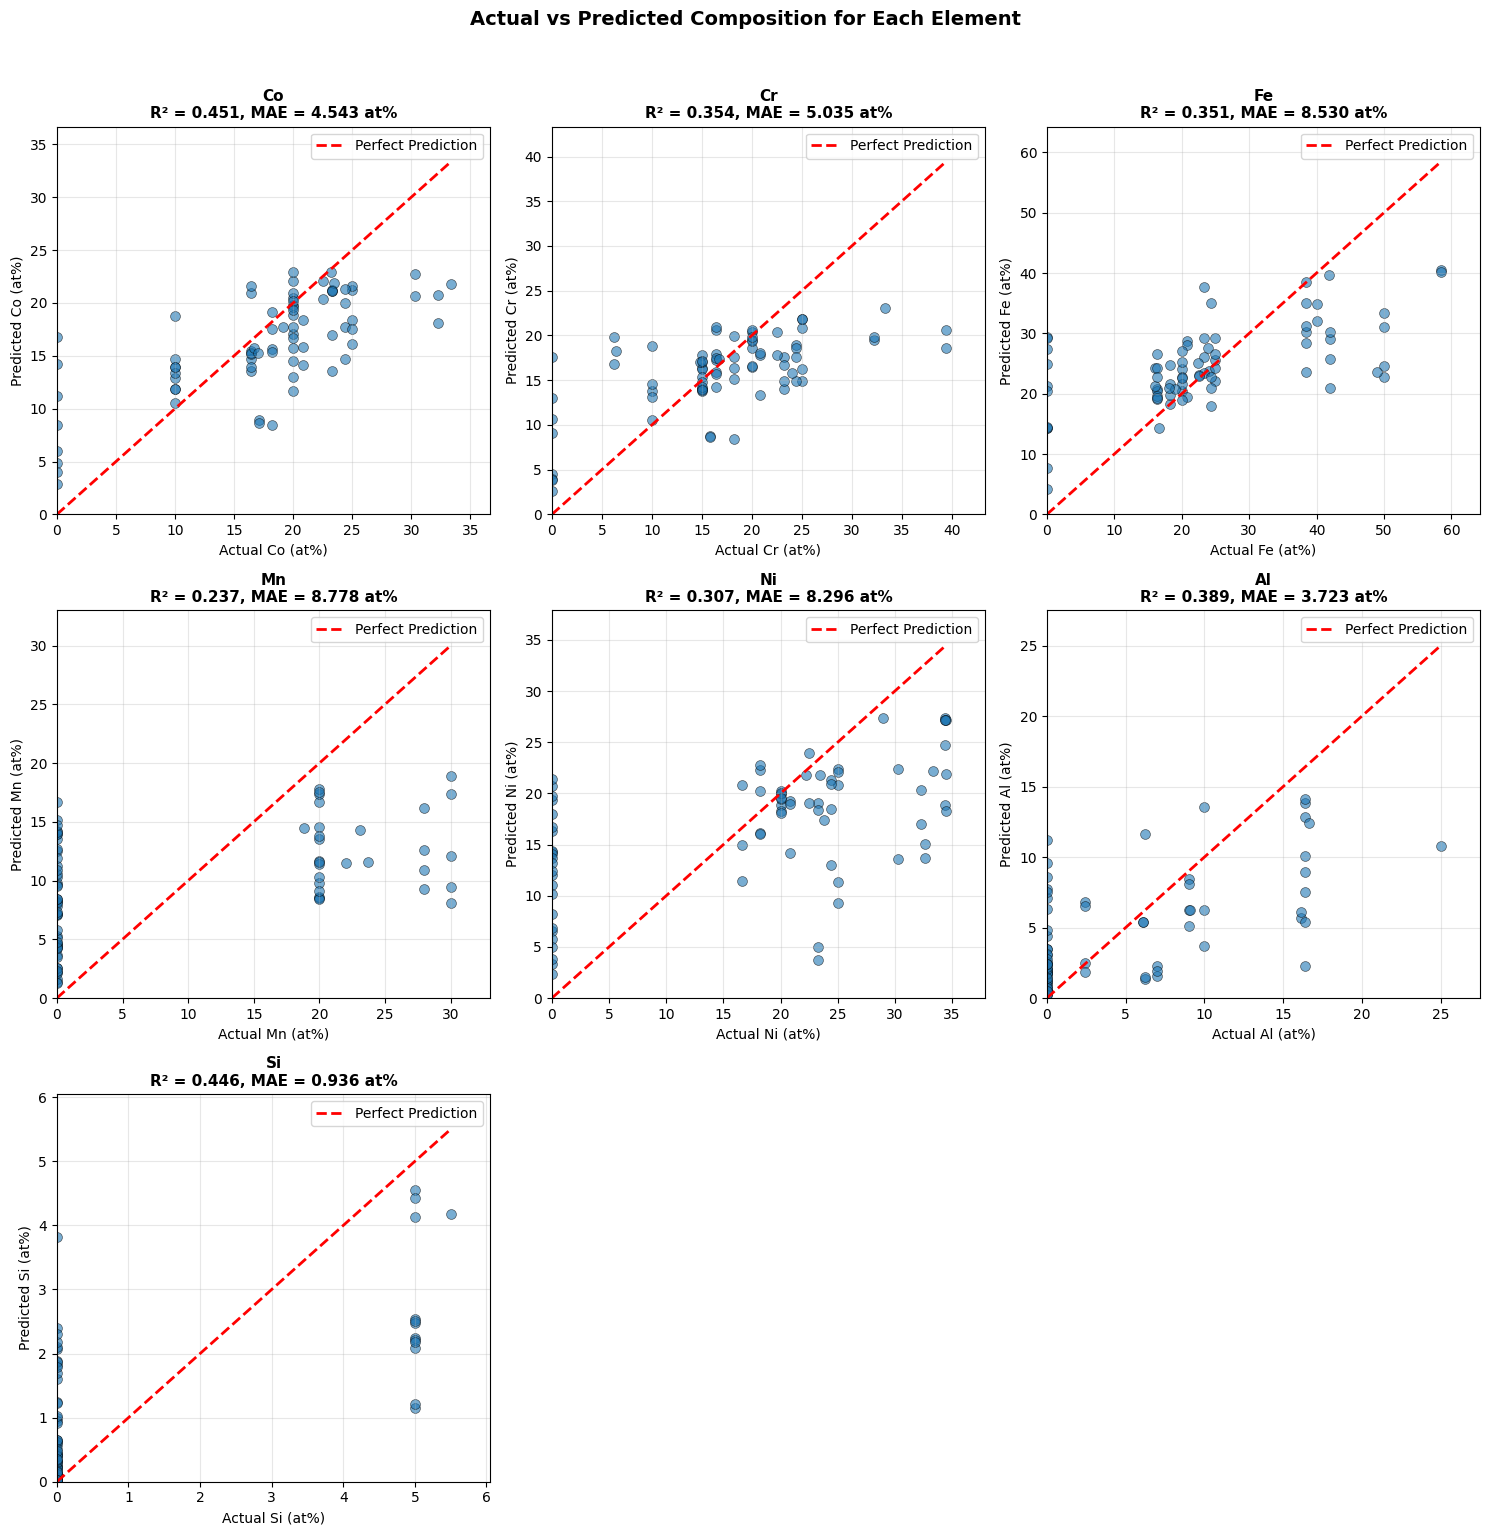


✓ Generated scatter plots for 7 elements


In [301]:
# Visualization: Actual vs Predicted Scatter Plots for Each Element
import matplotlib.pyplot as plt
import numpy as np

n_elements = len(main_elements)
cols = 3  # 3 plots per row
rows = int(np.ceil(n_elements / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten() if n_elements > 1 else [axes]

for i, element in enumerate(main_elements):
    ax = axes[i]
    actual = y_test_main[element].values
    predicted = y_pred[:, i]
    
    # Scatter plot
    ax.scatter(actual, predicted, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line (y=x)
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Labels and title
    r2 = r2_scores[i]
    mae = mae_scores[i]
    ax.set_xlabel(f'Actual {element} (at%)', fontsize=10)
    ax.set_ylabel(f'Predicted {element} (at%)', fontsize=10)
    ax.set_title(f'{element}\nR² = {r2:.3f}, MAE = {mae:.3f} at%', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Add diagonal bounds for better visualization
    ax.set_xlim([min_val * 0.9, max_val * 1.1])
    ax.set_ylim([min_val * 0.9, max_val * 1.1])

# Hide unused subplots
for j in range(n_elements, len(axes)):
    axes[j].axis('off')

plt.suptitle('Actual vs Predicted Composition for Each Element', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\n✓ Generated scatter plots for {n_elements} elements")

In [302]:
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import time

In [303]:
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not installed. Install with: pip install xgboost")

try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠️ CatBoost not installed. Install with: pip install catboost")

print("="*70)
print("🚀 MODEL PIPELINE: Random Forest + XGBoost + CatBoost")
print("="*70)

🚀 MODEL PIPELINE: Random Forest + XGBoost + CatBoost


In [304]:
# ============================================================
# STEP 1: Define Parameter Grids for Each Model
# ============================================================

# Random Forest Parameters
rf_param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [8, 10, 12],
    'estimator__min_samples_split': [5, 10, 15],
    'estimator__min_samples_leaf': [3, 5, 7],
    'estimator__max_features': ['sqrt', 'log2']
}

# XGBoost Parameters (if available)
if XGBOOST_AVAILABLE:
    xgb_param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [4, 6, 8],
    'estimator__learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
    }
    
# CatBoost Parameters (if available)
if CATBOOST_AVAILABLE:
    cat_param_grid = {
        'iterations': [100, 200, 300],
        'depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.15],
        'l2_leaf_reg': [1, 3, 5],
        'border_count': [32, 64]
    }
#HistGradientBoosting Parameters
# ✅ FIXED: Added 'estimator__' prefix for MultiOutputRegressor
histgb_param_grid = {
    'estimator__max_iter': [100, 200, 300, 500],
    'estimator__max_depth': [5, 10, 15, 20, None],
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.15],
    'estimator__min_samples_leaf': [5, 10, 20, 30],
    'estimator__max_leaf_nodes': [31, 50, 100, 200],
    'estimator__l2_regularization': [0.0, 0.1, 0.5, 1.0],
    'estimator__max_bins': [128, 255]
}

print("\n✓ Parameter grids defined for all models")



✓ Parameter grids defined for all models


In [305]:
# ============================================================
# STEP 2: Define Models with MultiOutput Wrapper
# ============================================================

# Base Random Forest
rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Base XGBoost (if available)
if XGBOOST_AVAILABLE:
    xgb_base = XGBRegressor(
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

# Base CatBoost (if available)
if CATBOOST_AVAILABLE:
    cat_base = CatBoostRegressor(
        random_state=42,
        verbose=False,
        thread_count=-1
    )

# Base HistGradientBoostingRegressor
histgb_base = HistGradientBoostingRegressor(
    random_state=42,
    verbose=0
)

print("✓ Base models defined")

✓ Base models defined


In [306]:
# ============================================================
# STEP 3: Hyperparameter Tuning Function
# ============================================================

def tune_model(model, param_grid, X_train, y_train, model_name, cv=3, n_iter=None):
    """
    Tune hyperparameters for a model using GridSearchCV or RandomizedSearchCV
    
    Parameters:
    -----------
    model : sklearn model
        Base model to tune
    param_grid : dict
        Parameter grid for tuning
    X_train : array
        Training features
    y_train : DataFrame
        Training targets (multi-output)
    model_name : str
        Name of the model (for printing)
    cv : int
        Number of CV folds
    n_iter : int or None
        If specified, use RandomizedSearchCV with n_iter iterations
        If None, use GridSearchCV (exhaustive search)
    
    Returns:
    --------
    best_model : fitted model
        Best model with tuned parameters
    best_params : dict
        Best parameters found
    """
    print(f"\n{'='*70}")
    print(f"🔍 Tuning {model_name}...")
    print(f"{'='*70}")
    
    # Wrap in MultiOutputRegressor
    multi_model = MultiOutputRegressor(model)
    
    start_time = time.time()
    
    # Use RandomizedSearchCV for faster search (recommended)
    if n_iter:
        search = RandomizedSearchCV(
            multi_model,
            param_grid,
            n_iter=n_iter,
            cv=cv,
            scoring='r2',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
    # Or GridSearchCV for exhaustive search (slower but thorough)
    else:
        search = GridSearchCV(
            multi_model,
            param_grid,
            cv=cv,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
    
    # Fit on training data
    search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    
    print(f"\n✓ {model_name} tuning complete!")
    print(f"  Time taken: {elapsed_time:.2f} seconds")
    print(f"  Best CV R² score: {search.best_score_:.4f}")
    print(f"  Best parameters:")
    for param, value in search.best_params_.items():
        print(f"    {param}: {value}")
    
    return search.best_estimator_, search.best_params_

In [285]:
# ============================================================
# STEP 4: Train and Tune All Models
# ============================================================

trained_models = {}
best_params_dict = {}

# Tune Random Forest
print("\n" + "="*70)
print("🌲 TUNING RANDOM FOREST")
print("="*70)

rf_best, rf_params = tune_model(
    rf_base, 
    rf_param_grid, 
    X_train_scaled, 
    y_train_main,
    model_name="Random Forest",
    cv=3,
    n_iter=20  # Use 20 random combinations (faster than exhaustive)
)
trained_models['RandomForest'] = rf_best
best_params_dict['RandomForest'] = rf_params

# Tune XGBoost (if available)
if XGBOOST_AVAILABLE:
    print("\n" + "="*70)
    print("⚡ TUNING XGBOOST")
    print("="*70)
    
    # Need to adjust param grid keys for MultiOutputRegressor
    xgb_param_grid_multi = {f'estimator__{k}': v for k, v in xgb_param_grid.items()}
    
    xgb_best, xgb_params = tune_model(
        xgb_base,
        xgb_param_grid_multi,
        X_train_scaled,
        y_train_main,
        model_name="XGBoost",
        cv=3,
        n_iter=20
    )
    trained_models['XGBoost'] = xgb_best
    best_params_dict['XGBoost'] = xgb_params
else:
    print("\n⚠️ Skipping XGBoost (not installed)")

# Tune CatBoost (if available)
if CATBOOST_AVAILABLE:
    print("\n" + "="*70)
    print("🐱 TUNING CATBOOST")
    print("="*70)
    
    # CatBoost handles multi-output natively, but need to wrap param grid
    cat_param_grid_multi = {f'estimator__{k}': v for k, v in cat_param_grid.items()}
    
    cat_best, cat_params = tune_model(
        cat_base,
        cat_param_grid_multi,
        X_train_scaled,
        y_train_main,
        model_name="CatBoost",
        cv=3,
        n_iter=15  # CatBoost can be slower
    )
    trained_models['CatBoost'] = cat_best
    best_params_dict['CatBoost'] = cat_params
else:
    print("\n⚠️ Skipping CatBoost (not installed)")

# Tune HistGradientBoosting
print("\n" + "="*70)
print("📊 TUNING HISTGRADIENTBOOSTING REGRESSOR")
print("="*70)

# Safety check: Define histgb_param_grid if not already defined
if 'histgb_param_grid' not in globals():
    histgb_param_grid = {
        'estimator__max_iter': [100, 200, 300, 500],
        'estimator__max_depth': [5, 10, 15, 20, None],
        'estimator__learning_rate': [0.01, 0.05, 0.1, 0.15],
        'estimator__min_samples_leaf': [5, 10, 20, 30],
        'estimator__max_leaf_nodes': [31, 50, 100, 200],
        'estimator__l2_regularization': [0.0, 0.1, 0.5, 1.0],
        'estimator__max_bins': [128, 255]
    }
    print("✓ HistGradientBoosting parameter grid defined")

histgb_best, histgb_params = tune_model(
    histgb_base,
    histgb_param_grid,  # Already has estimator__ prefix
    X_train_scaled,
    y_train_main,
    model_name="HistGradientBoosting",
    cv=3,
    n_iter=30  # 30 iterations for better tuning
)
trained_models['HistGradientBoosting'] = histgb_best
best_params_dict['HistGradientBoosting'] = histgb_params

print("\n" + "="*70)
print("✅ ALL MODELS TUNED AND TRAINED!")
print("="*70)


🌲 TUNING RANDOM FOREST

🔍 Tuning Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ Random Forest tuning complete!
  Time taken: 16.78 seconds
  Best CV R² score: 0.2623
  Best parameters:
    estimator__n_estimators: 200
    estimator__min_samples_split: 5
    estimator__min_samples_leaf: 3
    estimator__max_features: sqrt
    estimator__max_depth: 12

⚡ TUNING XGBOOST

🔍 Tuning XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ XGBoost tuning complete!
  Time taken: 10.43 seconds
  Best CV R² score: 0.2452
  Best parameters:
    estimator__subsample: 0.9
    estimator__reg_lambda: 1.5
    estimator__reg_alpha: 0
    estimator__estimator__n_estimators: 100
    estimator__estimator__max_depth: 4
    estimator__estimator__learning_rate: 0.1
    estimator__colsample_bytree: 0.8

🐱 TUNING CATBOOST

🔍 Tuning CatBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

✓ CatBoost tuning complete!
  Time taken: 22.32 second

In [307]:
# ============================================================
# STEP 5: Evaluate All Models
# ============================================================

print("\n" + "="*70)
print("📊 EVALUATING ALL MODELS")
print("="*70)

model_results = {}

for model_name, model in trained_models.items():
    print(f"\n🔍 Evaluating {model_name}...")
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics for each element
    r2_scores = []
    mae_scores = []
    
    for i, element in enumerate(main_elements):
        r2 = r2_score(y_test_main[element], y_pred[:, i])
        mae = mean_absolute_error(y_test_main[element], y_pred[:, i])
        r2_scores.append(r2)
        mae_scores.append(mae)
    
    avg_r2 = np.mean(r2_scores)
    avg_mae = np.mean(mae_scores)
    
    model_results[model_name] = {
        'R²': avg_r2,
        'MAE': avg_mae,
        'R²_scores': r2_scores,
        'MAE_scores': mae_scores,
        'predictions': y_pred
    }
    
    print(f"  Average R²: {avg_r2:.4f}")
    print(f"  Average MAE: {avg_mae:.4f} at%")
    print(f"  Per-element R²: {[f'{r2:.3f}' for r2 in r2_scores]}")


📊 EVALUATING ALL MODELS

🔍 Evaluating RandomForest...


ValueError: X has 54 features, but RandomForestRegressor is expecting 30 features as input.

In [287]:
# ============================================================
# STEP 6: Compare Models and Find Best
# ============================================================

print("\n" + "="*70)
print("🏆 MODEL COMPARISON")
print("="*70)
print(f"\n{'Model':<15} {'Average R²':>15} {'Average MAE':>15}")
print("-"*70)

for model_name, results in model_results.items():
    print(f"{model_name:<15} {results['R²']:>15.4f} {results['MAE']:>15.4f} at%")

# Find best model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['R²'])
best_model = trained_models[best_model_name]

print("\n" + "="*70)
print(f"🥇 BEST MODEL: {best_model_name}")
print(f"   R² Score: {model_results[best_model_name]['R²']:.4f}")
print(f"   MAE: {model_results[best_model_name]['MAE']:.4f} at%")
print("="*70)





🏆 MODEL COMPARISON

Model                Average R²     Average MAE
----------------------------------------------------------------------
RandomForest             0.3875          5.4161 at%
XGBoost                  0.3243          5.2063 at%
CatBoost                 0.3639          5.1695 at%
HistGradientBoosting          0.3418          5.2396 at%

🥇 BEST MODEL: RandomForest
   R² Score: 0.3875
   MAE: 5.4161 at%


In [288]:

# ============================================================
# STEP 8: Summary
# ============================================================

print("\n" + "="*70)
print("📋 PIPELINE SUMMARY")
print("="*70)
print(f"\n✓ Trained {len(trained_models)} models:")
for name in trained_models.keys():
    print(f"  - {name}")

print(f"\n✓ Best model: {best_model_name}")
print(f"✓ Best R² score: {model_results[best_model_name]['R²']:.4f}")

print("\n" + "="*70)
print("✅ PIPELINE COMPLETE!")
print("="*70)



📋 PIPELINE SUMMARY

✓ Trained 4 models:
  - RandomForest
  - XGBoost
  - CatBoost
  - HistGradientBoosting

✓ Best model: RandomForest
✓ Best R² score: 0.3875

✅ PIPELINE COMPLETE!
